In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r'C:\Users\njhar\Downloads\test_FD001.txt', sep=" ")

In [3]:

data.drop(columns=['Unnamed: 26','Unnamed: 27'],inplace=True)


In [4]:
# This is for Train and Test data

index_names = ['engine', 'cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names= ['s1',
               's2',
               's3',
               's4',
               's5',
               's6',
               's7',
               's8',
               's9',
               's10',
               's11',
               's12',
               's13',
               's14',
               's15',
               's16',
               's17',
               's18',
               's19',
               's20',
               's21']
col_names = index_names + setting_names + sensor_names

In [5]:

data.columns = col_names


In [6]:
# Dropping sensors from the Test data
test_unwanted=[]
for i in data.select_dtypes(include=np.number):
    if data[i].nunique()==1:
        test_unwanted.append(i)
print(test_unwanted)

['setting_3', 's1', 's5', 's10', 's16', 's18', 's19']


In [7]:
# so we will drop such columns

data.drop(columns=test_unwanted, inplace=True)

In [8]:
data['cycles'].max()

303

In [9]:
data_train_RUL = data.groupby(['engine']).agg({'cycles':'max'})
data_train_RUL.rename(columns={'cycles':'life'},inplace=True)
data_train_RUL.head()

,life
engine,
1,31
2,49
3,126
4,106
5,98


In [10]:
data_train = data.merge(data_train_RUL,how='left',on=['engine'])

In [11]:
data_train['RUL'] = data_train['life'] - data_train['cycles']
data_train.drop(['life'],axis=1,inplace=True)

In [12]:
data_train.head()

,engine,cycles,setting_1,setting_2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,29
1,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,28
2,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,27
3,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,26
4,1,6,0.0012,0.0003,642.11,1579.12,1395.13,21.61,554.22,2388.00,9050.96,47.26,521.92,2388.08,8127.46,8.4238,392,38.91,23.3467,25


In [13]:
# Example: Select relevant sensor data and the operational settings
features = data_train[['setting_1', 'setting_2',
               's2',
               's3',
               's4',
               's6',
               's7',
               's8',
               's9',
               's11',
               's12',
               's13',
               's14',
               's15',
               's17',
               's20',
               's21']]
target = data_train['RUL']  # RUL = Remaining Useful Life (assumed to be in the dataset)

In [14]:
# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [15]:
# Convert RUL to Life Ratio
data_train['Life_Ratio'] = 1 - data_train['RUL'] / data_train.groupby('engine')['RUL'].transform('max')

In [16]:
# Define classification labels based on Life Ratio
def classify_life_ratio(life_ratio):
    if life_ratio < 0.7:
        return 0  # Safe
    elif 0.7 <= life_ratio < 0.9:
        return 1  # Warning
    else:
        return 2  # Critical

data_train['Life_Class'] = data_train['Life_Ratio'].apply(classify_life_ratio)

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, data_train['Life_Class'], test_size=0.2, random_state=42)

In [17]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1821
           1       0.55      0.24      0.34       524
           2       0.71      0.27      0.40       274

    accuracy                           0.75      2619
   macro avg       0.68      0.50      0.53      2619
weighted avg       0.72      0.75      0.71      2619

Accuracy: 0.7522


In [18]:
# XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1821
           1       0.48      0.26      0.34       524
           2       0.69      0.27      0.39       274

    accuracy                           0.74      2619
   macro avg       0.65      0.49      0.53      2619
weighted avg       0.71      0.74      0.70      2619

Accuracy: 0.7384


In [19]:
# Support Vector Classifier
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, svc_pred))
print(f"Accuracy: {accuracy_score(y_test, svc_pred):.4f}")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1821
           1       0.61      0.14      0.23       524
           2       0.88      0.16      0.28       274

    accuracy                           0.74      2619
   macro avg       0.74      0.43      0.45      2619
weighted avg       0.73      0.74      0.67      2619

Accuracy: 0.7392


In [20]:
# Logistic Regression
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1821
           1       0.54      0.15      0.24       524
           2       0.65      0.25      0.36       274

    accuracy                           0.74      2619
   macro avg       0.65      0.46      0.49      2619
weighted avg       0.70      0.74      0.68      2619

Accuracy: 0.7411


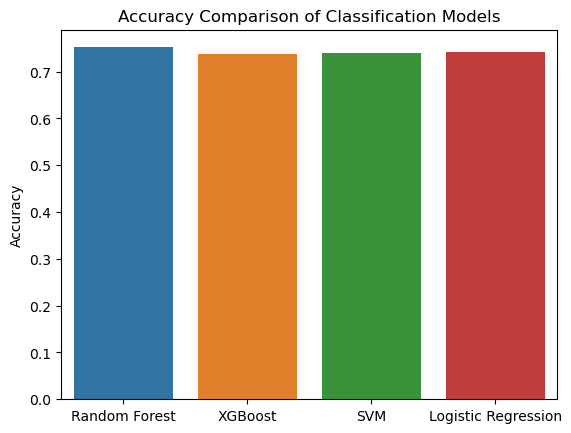

In [21]:
# Compare accuracy across models
results = {
    'Random Forest': accuracy_score(y_test, rf_pred),
    'XGBoost': accuracy_score(y_test, xgb_pred),
    'SVM': accuracy_score(y_test, svc_pred),
    'Logistic Regression': accuracy_score(y_test, lr_pred)
}

# Plot the results
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Accuracy Comparison of Classification Models")
plt.ylabel("Accuracy")
plt.show()

In [23]:
# Function to classify a specific engine using the trained models
def classify_engine(engine_id, engine_data, models):
    # Filter data for the specific engine
    specific_engine_data = data_train[data_train['engine'] == engine_id]
    
    # Preprocess the features as done before (scaling)
    specific_engine_features = specific_engine_data[['setting_1', 'setting_2',
               's2',
               's3',
               's4',
               's6',
               's7',
               's8',
               's9',
               's11',
               's12',
               's13',
               's14',
               's15',
               's17',
               's20',
               's21']]
    specific_engine_features_scaled = scaler.transform(specific_engine_features)
    
    # Test the models on this specific engine
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(specific_engine_features_scaled)
        results[model_name] = predictions
    
    return results, specific_engine_data['Life_Class'].values  # Return true labels for comparison

# Define available models
available_models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'SVM': svc_model,
    'Logistic Regression': lr_model
}

# Function to get selected models from user input
def select_models():
    print("Available models:")
    for i, model_name in enumerate(available_models.keys()):
        print(f"{i + 1}. {model_name}")

    # Get user selection
    selected_indices = input("Select models (comma-separated numbers, e.g., 1,2): ").split(',')
    selected_indices = [int(i.strip()) - 1 for i in selected_indices if i.strip().isdigit()]

    # Create models dictionary based on user selection
    models = {}
    for index in selected_indices:
        if index >= 0 and index < len(available_models):
            model_name = list(available_models.keys())[index]
            models[model_name] = available_models[model_name]

    return models

# Get the models to be used
models = select_models()

# Now you can use the models dictionary in your classification function

# Get engine ID from user input
engine_id_to_test = int(input("Enter Engine ID to test: "))

# Classify the specific engine using all models
classification_results, true_labels = classify_engine(engine_id_to_test, data, models)


Available models:
1. Random Forest
2. XGBoost
3. SVM
4. Logistic Regression
Select models (comma-separated numbers, e.g., 1,2): 3
Enter Engine ID to test: 4



Model: SVM
Predicted Classifications: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


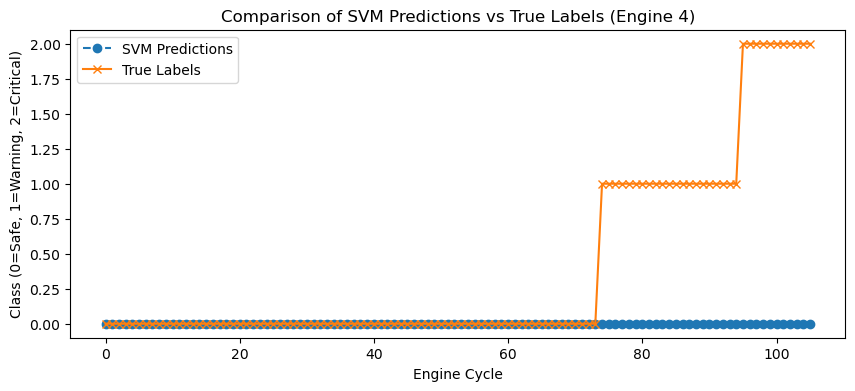

In [24]:
# Display the classification results for the specific engine
for model_name, predictions in classification_results.items():
    print(f"\nModel: {model_name}")
    print(f"Predicted Classifications: {predictions}")
    print(f"True Labels: {true_labels}")

# Plot comparison between true and predicted values for each model
for model_name, predictions in classification_results.items():
    plt.figure(figsize=(10, 4))
    plt.plot(predictions, label=f'{model_name} Predictions', linestyle='--', marker='o')
    plt.plot(true_labels, label='True Labels', linestyle='-', marker='x')
    plt.title(f'Comparison of {model_name} Predictions vs True Labels (Engine {engine_id_to_test})')
    plt.xlabel('Engine Cycle')
    plt.ylabel('Class (0=Safe, 1=Warning, 2=Critical)')
    plt.legend()
    plt.show()